# Simple Quark / Gluon discrimination example 

This is a simple example which uses jet shapes and a simple fully-connected Keras network to distinguish quark and gluon jets.

To use have the keras progressbar in this notebook, please install keras_tqdm in a terminal
```
pip install --user keras_tqdm
```
Note, however, that there is a known problem with pip in LCG88 (see [here](https://gitlab.cern.ch/IML-WG/IMLWorkshop2017-Challenge/blob/master/KnownIssues.md))


Make sure that the Keras backand is properly configured for Swan (theano) in your rc file:

```
$ cat $HOME/.keras/keras.json 
{ 
"image_dim_ordering": "tf", 
"epsilon": 1e-07, 
"floatx": "float32", 
"backend": "theano" 
} 

```

**TODO: Fix path for modified jets**


In [1]:
%%bash
# This only needs to be executed the first time, comment it out if you used it already once.
# it installs an additional keras package and the extensions for the progress bar
# YOU NEED TO EXECUTE THIS ONLY THE FIRST TIME YOU RUN ON A SPECIFIC SWAN MACHINE (e.g. swan-002) and 
# YOU HAVE TO REFRESH THE PAGE FOR THE PROGRESSBARS TO SHOW
jupyter nbextension enable --py widgetsnbextension 

Unrecognized JSON config file version, assuming version 1
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import keras, ROOT, sklearn
import flat_helper
import numpy
# from keras_tqdm import TQDMNotebookCallback # uncomment this to get the progress bar
import theano
theano.config.gcc.cxxflags = '-march=corei7' 

Using Theano backend.


Welcome to JupyROOT 6.08/06


In [3]:
# load jet shapes
# Limit the number of events: for this simple method we don't need a huge statistics
# The second argument indicates the number of jets to process (use -1 to process all available jets).
# The GetJetShapes[Fast] functions return a pandas data frame, and saves it to a  file for reuse. 
# If the file exist, the trees are not reprocessed. To force reprocessing (e.g. you want to include 
# more statistics) use the recompute=True argument.
# The calculation of jet shapes in the GetJetShapes function is somewhat slow, as the loops for the 
# computation run in python
# in GetJetShapesFast the computation is implemented in an external C macro


dfQuarks = flat_helper.GetJetShapesFast('/eos/project/i/iml/IMLChallengeQG/quarks_standard', 20000, recompute=False)
dfGluons = flat_helper.GetJetShapesFast('/eos/project/i/iml/IMLChallengeQG/gluons_standard', 20000, recompute=False)

Loading from root file _eos_project_i_iml_IMLChallengeQG_quarks_standard_shapes.root
Loading from root file _eos_project_i_iml_IMLChallengeQG_gluons_standard_shapes.root


In [4]:
# set labels
dfQuarks['isGluon'] = 0
dfGluons['isGluon'] = 1

In [5]:
dfQuarks.head()

,mass,ntowers,radial,dispersion,isGluon
0,8.275855,0.0,0.000000,0.000000,0
1,18.406378,2.0,0.000000,0.000000,0
2,8.124520,6.0,0.400834,0.448262,0
3,4.995439,3.0,0.170562,0.561912,0
4,7.139542,4.0,0.237577,0.445743,0


In [6]:
dfGluons.head()

,mass,ntowers,radial,dispersion,isGluon
0,20.549572,11.0,0.000000,0.000000,1
1,9.343444,3.0,0.566082,0.294961,1
2,16.000256,17.0,0.285827,0.405563,1
3,9.567515,10.0,0.593621,0.612770,1
4,7.662630,14.0,0.004826,1.000000,1


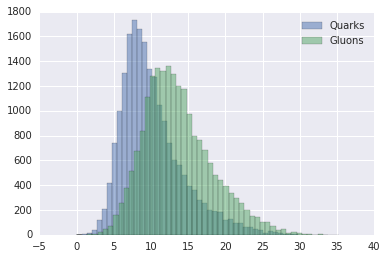

In [7]:
# some basic plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # cosmetics
%matplotlib inline
plt.hist(dfQuarks.mass, bins=50, alpha=0.5, label='Quarks');
plt.hist(dfGluons.mass, bins=50, alpha=0.5, label='Gluons');
plt.legend();

In [8]:
# Import some keras deps
from    keras.models       import Sequential
from    keras.layers       import Dense, Dropout
from    keras.regularizers import l2
import  keras.backend

In [9]:
import pandas as pd
labels = pd.concat([dfQuarks['isGluon'],dfGluons['isGluon']])
trainData = pd.concat([dfQuarks.drop('isGluon',axis=1), dfGluons.drop('isGluon',axis=1)])
trainData.head()

,mass,ntowers,radial,dispersion
0,8.275855,0.0,0.000000,0.000000
1,18.406378,2.0,0.000000,0.000000
2,8.124520,6.0,0.400834,0.448262
3,4.995439,3.0,0.170562,0.561912
4,7.139542,4.0,0.237577,0.445743


In [10]:
from sklearn.cross_validation import train_test_split
rawXtrain, rawXtest, ytrain, ytest = train_test_split(trainData, labels, random_state=1)

In [11]:
# Change data format for Keras
Xtrain = rawXtrain.as_matrix()
Xtest = rawXtest.as_matrix()

In [12]:
# Compile simple Keras model: fully-connected, multi-layer

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(4,)))
model.add(Dropout(0.2))
model.add(Dense(100, activation='tanh', W_regularizer=l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation='tanh', W_regularizer=l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation='tanh', W_regularizer=l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid', init='he_normal'))

model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

WARNING (theano.gof.cmodule): WARNING: your Theano flags `gcc.cxxflags` specify an `-march=X` flags.
         It is better to let Theano/g++ find it automatically, but we don't do it now


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 128)           640         dense_input_1[0][0]              
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 128)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 100)           12900       dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 100)           0           dense_2[0][0]                    
___________________________________________________________________________________________

         It is better to let Theano/g++ find it automatically, but we don't do it now


In [13]:
numEpochs = 20
learningRate = 0.01
batchSize = 100

# Workaround to set learning rate (compatible with theano and tensorflow)
keras.backend.set_value(model.optimizer.lr, learningRate)


# uncomment this and comment the next one to get the progress bar
# hist = model.fit(Xtrain, ytrain, nb_epoch=numEpochs, batch_size=batchSize,
#             validation_data=(Xtest, ytest), verbose=8, callbacks=[TQDMNotebookCallback()])

hist = model.fit(Xtrain, ytrain, nb_epoch=numEpochs, batch_size=batchSize,
            validation_data=(Xtest, ytest), verbose=1)

Train on 30000 samples, validate on 10000 samples
Epoch 1/20
30000/30000 [==============================] - 5s - loss: 0.8060 - acc: 0.6456 - val_loss: 0.5981 - val_acc: 0.6936
Epoch 2/20
30000/30000 [==============================] - 5s - loss: 0.6209 - acc: 0.6860 - val_loss: 0.5887 - val_acc: 0.6962
Epoch 3/20
30000/30000 [==============================] - 5s - loss: 0.6277 - acc: 0.6863 - val_loss: 0.5899 - val_acc: 0.6996
Epoch 4/20
30000/30000 [==============================] - 5s - loss: 0.6178 - acc: 0.6895 - val_loss: 0.6084 - val_acc: 0.6877
Epoch 5/20
30000/30000 [==============================] - 6s - loss: 0.6250 - acc: 0.6862 - val_loss: 0.5955 - val_acc: 0.6944
Epoch 6/20
30000/30000 [==============================] - 8s - loss: 0.6246 - acc: 0.6892 - val_loss: 0.5890 - val_acc: 0.6988
Epoch 7/20
30000/30000 [==============================] - 8s - loss: 0.6229 - acc: 0.6908 - val_loss: 0.5884 - val_acc: 0.6999
Epoch 8/20
30000/30000 [==============================] - 8s 

In [14]:
testPrediction = model.predict_classes(Xtest, verbose=0)
testPrediction = testPrediction.flatten()

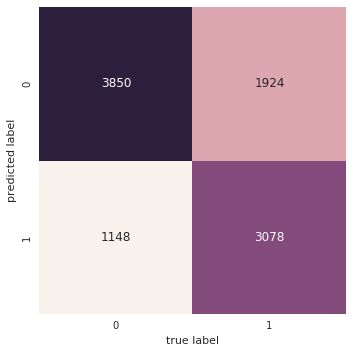

In [15]:
#Confusion matrix

%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, testPrediction)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
#                xticklabels=testLabels, yticklabels=testLabels)
plt.xlabel('true label')
plt.ylabel('predicted label');

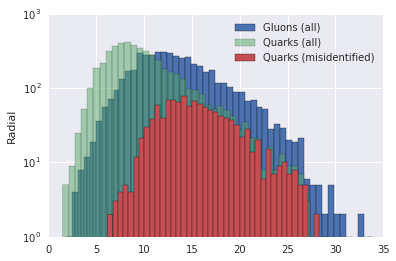

In [16]:
# Get some insight on misentification: quarks misidentified as gluons have larger mass on average, 
# they are much more gluon like
variableToPlot='mass'

import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(rawXtest[ytest == 1][variableToPlot], bins=50, alpha=1, label='Gluons (all)');
plt.hist(rawXtest[ytest == 0][variableToPlot], bins=50, alpha=0.5, label='Quarks (all)');
plt.hist(rawXtest[(testPrediction != ytest) & (ytest == 0)][variableToPlot], bins=50, alpha=1, label='Quarks (misidentified)');
plt.gca().set_yscale("log")
plt.ylabel('Radial')
plt.legend();

In [17]:
# Keras can also estimate probability, which we can use to plot a ROC curve
y_score = model.predict_proba(Xtest, verbose=0)

In [18]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(ytest,y_score[:,0])
roc_auc = auc(fpr,tpr) 


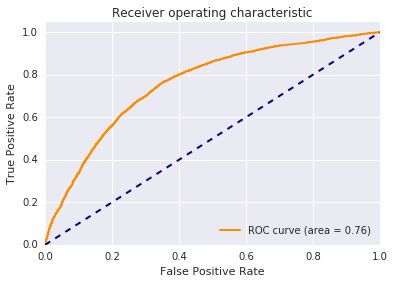

In [19]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Testing on modified dataset
in the following cells, we use the model on the modified dataset

In [20]:
dfQuarksMod = flat_helper.GetJetShapesFast('/eos/project/i/iml/IMLChallengeQG/quarks_standard', -1, recompute=False)
dfGluonsMod = flat_helper.GetJetShapesFast('/eos/project/i/iml/IMLChallengeQG/gluons_standard', -1, recompute=False)

Loading from root file _eos_project_i_iml_IMLChallengeQG_quarks_standard_shapes.root
Loading from root file _eos_project_i_iml_IMLChallengeQG_gluons_standard_shapes.root


In [21]:
dfQuarksMod['isGluon'] = 0
dfGluonsMod['isGluon'] = 1
dfQuarksMod.head()

,mass,ntowers,radial,dispersion,isGluon
0,8.275855,0.0,0.000000,0.000000,0
1,18.406378,2.0,0.000000,0.000000,0
2,8.124520,6.0,0.400834,0.448262,0
3,4.995439,3.0,0.170562,0.561912,0
4,7.139542,4.0,0.237577,0.445743,0


In [22]:
dfGluonsMod.head()

,mass,ntowers,radial,dispersion,isGluon
0,20.549572,11.0,0.000000,0.000000,1
1,9.343444,3.0,0.566082,0.294961,1
2,16.000256,17.0,0.285827,0.405563,1
3,9.567515,10.0,0.593621,0.612770,1
4,7.662630,14.0,0.004826,1.000000,1


In [23]:
labelsMod = pd.concat([dfQuarksMod['isGluon'],dfGluonsMod['isGluon']])
testDataMod = pd.concat([dfQuarksMod.drop('isGluon',axis=1), dfGluonsMod.drop('isGluon',axis=1)])
testDataMod.head()

,mass,ntowers,radial,dispersion
0,8.275855,0.0,0.000000,0.000000
1,18.406378,2.0,0.000000,0.000000
2,8.124520,6.0,0.400834,0.448262
3,4.995439,3.0,0.170562,0.561912
4,7.139542,4.0,0.237577,0.445743


In [24]:
y_score_mod = model.predict_proba(testDataMod.as_matrix())

39968/40000 [============================>.] - ETA: 0s

In [25]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(ytest,y_score[:,0])
roc_auc = auc(fpr,tpr) 

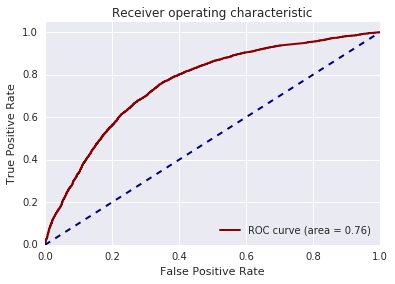

In [26]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkred',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [27]:
# Save AUC value
f = open("imlcoordinators_v1_auc.txt","w") 
f.write(str(roc_auc))
f.close()